# VPSolver: Cutting & Packing Problems
[![vpsolver.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/vpsolver/vpsolver.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/vpsolver/vpsolver.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/vpsolver/vpsolver.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/vpsolver/vpsolver.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/vpsolver/vpsolver.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/vpsolver/vpsolver.ipynb)](https://colab.ampl.com)

Description: Solving cutting & packing problems using arc-flow formulations

Tags: industry, cutting-stock, bin-packing, vector-packing

Notebook author: Filipe Brandão <<fdabrandao@gmail.com>>

Model author: Filipe Brandão

References:
1. [Brandão, F. (2017). Cutting & Packing Problems: General Arc-flow Formulation with Graph Compression.](https://vpsolver.fdabrandao.pt/)

In [ ]:
# Install dependencies
!apt -qq install libgraphviz-dev
%pip install -q amplpy pygraphviz pyvpsolver

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Instance preparation:

1. Define a multiple-choice vector bin packing instance:

In [3]:
from pyvpsolver import VPSolver, MVP, AFG, MPS

Ws, Cs, Qs = [(5180, 9), (5189, 9)], [1, 1], [-1, -1]
ws = [[(1120, 1)], [(1250, 1)], [(520, 1)], [(1066, 1)], [(1000, 1)], [(1150, 1)]]
b = [9, 5, 91, 18, 11, 64]
instance = MVP(Ws, Cs, Qs, ws, b)

2. Build an arc-flow graph for the instance defined above:


VPSolver 3.1.3, Copyright (C) 2013-2016, Filipe Brandao
Build (method = -3)
  #dp: 163
  Step-3' Graph: 50 vertices and 199 arcs (0.00s)
  Step-4' Graph: 39 vertices and 132 arcs (0.00s)
  #V4/#V3 = 0.78
  #A4/#A3 = 0.66
Ready! (0.00s)


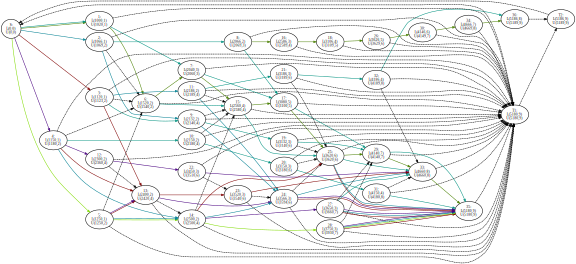

In [4]:
afg = AFG(instance)
from IPython.display import SVG

afg.draw("graph_vbp.svg", lpaths=True, graph_attrs={"size": "8,8"})
SVG("graph_vbp.svg")

## Model

In [5]:
%%ampl_eval
reset;
set V;
set A dimen 4;
var Flow{A} integer >= 0;

set Targets;
param Cost{Targets};
param Quantity{Targets};
minimize TotalCost:
    sum{t in Targets} Cost[t] * Flow[t,'S',-1,-1];
s.t. BinQuantity{t in Targets: Quantity[t] >= 0}:
    Flow[t,'S',-1,-1] <= Quantity[t];

set Items;
param Demand{Items};
s.t. SatisfyDemand{i in Items}:
    sum{(u,v,i,j) in A} Flow[u,v,i,j] >= Demand[i];

s.t. FlowConservation{k in V}:
    (sum{(u,v,i,j) in A: v == k} Flow[u,v,i,j]) - (sum{(u,v,i,j) in A: u == k} Flow[u,v,i,j]) == 0;

## Data

In [6]:
graph = afg.graph()
ampl.set["Items"] = list(range(len(b)))
ampl.param["Demand"] = instance.b
ampl.set["Targets"] = graph.Ts
ampl.param["Cost"] = instance.Cs
ampl.param["Quantity"] = instance.Qs
ampl.set["V"] = graph.V
ampl.set["A"] = [
    (u, v) + l if l != graph.LOSS else (u, v, -1, -1) for u, v, l in graph.A
]

## Solve

In [7]:
ampl.option["solver"] = "highs"
ampl.solve()

HiGHS 1.2.2: HiGHS 1.2.2: optimal solution; objective 33
1 branching nodes
absmipgap=7.10543e-14, relmipgap=2.15316e-15


## Extrat solution for the original problem

In [8]:
values = ampl.get_data(
    "{(u,v,i,j) in A: round(Flow[u,v,i,j]) > 0} round(Flow[u,v,i,j])"
).to_dict()
flows = {}
for (u, v, i, j), value in values.items():
    u = u if isinstance(u, str) else int(u)
    v = v if isinstance(v, str) else int(v)
    l = graph.LOSS if i == -1 else (int(i), int(j))
    flows[u, v, l] = int(value)
    assert (u, v, l) in graph.A
graph.flow = flows
graph.labels = {(u, v, lbl): [lbl] for (u, v, lbl) in graph.A if lbl != graph.LOSS}
for i in range(len(Ws)):
    total_flow = flows.get((graph.Ts[i], "S", graph.LOSS), 0)
    sol = graph.extract_solution(graph.S, "<-", graph.Ts[i], flow_limit=total_flow)
    assert sum(m for m, p in sol) == total_flow
    print(
        "Bins of type {0}: {1} {2}".format(
            i + 1, total_flow, ["bins", "bin"][total_flow == 1]
        )
    )
    for mult, patt in sol:
        print(
            "\t"
            + "{0} x [{1}]".format(
                mult, ", ".join([f"i={it+1} opt={opt+1}" for it, opt in patt])
            )
        )

Bins of type 1: 0 bins
Bins of type 2: 33 bins
	11 x [i=3 opt=1, i=3 opt=1, i=3 opt=1, i=3 opt=1, i=3 opt=1, i=3 opt=1, i=4 opt=1, i=5 opt=1]
	15 x [i=3 opt=1, i=6 opt=1, i=6 opt=1, i=6 opt=1, i=6 opt=1]
	4 x [i=1 opt=1, i=1 opt=1, i=2 opt=1, i=3 opt=1, i=6 opt=1]
	1 x [i=1 opt=1, i=3 opt=1, i=4 opt=1, i=4 opt=1, i=4 opt=1]
	1 x [i=2 opt=1, i=3 opt=1, i=4 opt=1, i=4 opt=1, i=4 opt=1]
	1 x [i=1 opt=1, i=3 opt=1, i=3 opt=1, i=3 opt=1, i=3 opt=1, i=3 opt=1, i=4 opt=1]
